In [1]:
import os
import random
from PIL import Image
from random import randint
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import networkx as nx

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
input_folder = r'/content/drive/MyDrive/data/deadends/train/input'
label_folder = r'/content/drive/MyDrive/data/deadends/train/label'

# folder where images will be outputed to
binary_folder = r'/content/drive/MyDrive/data/deadends/train/binary'

In [5]:
# binaryzation

def is_rock(pixel, threshold):
    """
    check if a triple is of white spectrum, if yes returns 1, if no returns 0
    """
    r, g, b = pixel
    if (r > threshold) and (g > threshold) and (b > threshold):
        return 1
    return 0

def fluid_mask(img: np.ndarray):
    """
    Creates a mask that assumes value 1 for regions where fluid is present and value 0 otherwise
    """
    mask = np.zeros([200, 200], dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            pixel = img[i, j, :]
            if(is_rock(pixel, 110)):
                mask[i, j] = 0
            else:
                mask[i, j] = 1
    return mask * 255

In [8]:
# transform images and seve it to folder

for filename in os.listdir(input_folder):
    img = np.array(Image.open(os.path.join(input_folder, filename)))
    binary_img = Image.fromarray(fluid_mask(img))
    binary_img.save(os.path.join(binary_folder, filename))

In [6]:
input_test_folder = r'/content/drive/MyDrive/data/deadends/test/input'
label_test_folder = r'/content/drive/MyDrive/data/deadends/test/label'

binary_test_folder = r'/content/drive/MyDrive/data/deadends/test/binary'

In [ ]:
# transform images and seve it to folder

for filename in os.listdir(input_test_folder):
    img = np.array(Image.open(os.path.join(input_test_folder, filename)))
    binary_img = Image.fromarray(fluid_mask(img))
    binary_img.save(os.path.join(binary_test_folder, filename))

In [9]:
# data augmentation using albumentations library


img_names = sorted(os.listdir(binary_folder))
mask_names = sorted(os.listdir(label_folder))

os.makedirs('/content/data/train/input', exist_ok=True)
os.makedirs('/content/data/train/label', exist_ok=True)

for i in range(1, 501):
    img1 = Image.open(os.path.join(binary_folder,  img_names[i-1]))
    img2 = Image.open(os.path.join(label_folder, mask_names[i-1]))

    for j in range(1, 2):
        img1_np = np.array(img1)
        img2_np = np.array(img2)
        random.seed(j)
        np.random.seed(j)
        torch.manual_seed(j)

        transform = A.ReplayCompose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.5,
                scale_limit=(0, 1.3),
                rotate_limit=180,
                border_mode=cv2.BORDER_REFLECT,
                p=1.0
            ),
            A.GridDistortion(num_steps=4, distort_limit=0.2, p=1.0),
            A.RandomResizedCrop(
                size=(200, 200),
                scale=(0.8, 1.0),
                ratio=(0.75, 1.33),
                interpolation=cv2.INTER_LINEAR,
                mask_interpolation=cv2.INTER_NEAREST,
                p=1.0
            ),
            A.ToGray(p=1.0),
            A.Resize(height=160, width=160, p=1.0),
            ToTensorV2()
        ])

        aug1 = transform(image=img1_np)
        replay = aug1["replay"]
        aug2 = A.ReplayCompose.replay(replay, image=img2_np)

        input_save_path = os.path.join(r'/content/data/train/input', str((i-1)*1 + j) + ".png")
        label_save_path = os.path.join(r'/content/data/train/label', str((i-1)*1 + j) + ".png")

        aug1_img = Image.fromarray(aug1["image"].cpu().permute(1, 2, 0).numpy().squeeze())
        aug2_img = Image.fromarray(aug2["image"].cpu().permute(1, 2, 0).numpy().squeeze())

        aug1_img.save(input_save_path)
        aug2_img.save(label_save_path)



In [13]:
# obtaining metadata

INF = 999.0

def calculate_tortuosity(mask: np.ndarray, start: tuple, end: tuple):
    """
    Calculate tortuosity using Dijkstra algorithm.

    Args:
        mask (numpy ndarray): binary mask.
        start (tuple of ints): (x, y) start point coordinates.
        end (tuple of ints): (x, y) end point coordinates.

    Returns:
        float: the tortuosity between the two `start` and `end` points
        None: if there is no conection between them
    """
    G = nx.grid_2d_graph(*mask.shape)
    for (x, y) in list(G.nodes):
        if mask[x, y] == 0:
            G.remove_node((x, y))

    for edge in G.edges:
        G.edges[edge]['weight'] = 1

    try:
        path = nx.shortest_path(G, source=start, target=end, weight='weight')
        length_real = nx.shortest_path_length(G, source=start, target=end, weight='weight') # djikstra algorithm
    except nx.NetworkXNoPath:
        return None
    length_direct = np.linalg.norm(np.array(start) - np.array(end))
    tau = length_real / length_direct
    return tau

# set of all possible coordenates for chossing points

# this work for all images:
def list_points(img_array: np.ndarray):
    """
    Iterate over a numpy 2D array to check for valid points (points where value equals 1.0)

    Args:
        img_array (numpy ndarray): Binary image where the iteration will be performed
    """
    valid_points = []
    for i in range(img_array.shape[0]):
        for j in range(img_array.shape[1]):
            if img_array[i, j] == 1:
                valid_points.append((i, j))
    return valid_points

def iterative_tortuosity(mask: np.ndarray, n: int, valids: list):

    if len(valids) == 0:
        return 1 # study if 1 is really the best choice

    final_tortuosity = 0.0
    denominator = n
    for i in range(0, n):
        start = valids[randint(0, len(valids)-1)]
        end = valids[randint(0, len(valids)- 1)]
        while (start[0] == end[0] and start[1] == end[1]):
            end = valids[randint(0, len(valids)- 1)]
        tortuosity = calculate_tortuosity(mask, start, end)
        if tortuosity == None:
            denominator -= 1
            continue
        else:
            final_tortuosity += tortuosity
    if denominator <= 0:
        return INF # by deffinition, with there is no path, tortuosity is infinity
    return (final_tortuosity/denominator).item()

input_aug_folder = r'/content/data/train/input'
label_aug_folder = r'/content/data/train/label'

def calculate_metadata(folder_path: str):
    metadata = []
    num_imgs = len(os.listdir(folder_path))
    for _ in range(0, num_imgs):
        metadata.append(torch.zeros(3))

    percent20 = False
    percent40 = False
    percent60 = False
    percent80 = False
    i = 0
    for filename in sorted(os.listdir(folder_path), key=lambda x: int(x.split(".")[0])):
        img = np.array(Image.open(os.path.join(folder_path, filename)), dtype=np.float32) / 255

        # calculate porosity
        phi = (np.sum(img == 1)/ (200 * 200)).item()
        metadata[i][0] = phi

        # calculate tortuosity
        pores = list_points(img)
        tau = iterative_tortuosity(img, 1, pores)
        metadata[i][1] = tau

        # pseudo-permeability kozeny-carman equation (without the constant)
        k = (phi**3)/((1 - phi)**2 * tau**2)

        metadata[i][2] = k


        i += 1
        if (i / num_imgs > 0.8 and percent80 == False):
            print("80%")
            percent80 = True
            continue
        if (i / num_imgs > 0.6 and percent60 == False):
            print("60%")
            percent60 = True
            continue
        if (i / num_imgs > 0.4 and percent40 == False):
            print("40%")
            percent40 = True
            continue
        if (i / num_imgs > 0.2 and percent20 == False):
            print("20%")
            percent20 = True
    print("100%")
    return metadata

print("-----train metadata-----")
train_metadata = calculate_metadata(input_aug_folder)
print("-----test  metadata-----")
test_metadata = calculate_metadata(binary_test_folder)

-----train metadata-----
20%
40%
60%
80%
100%
-----test  metadata-----
20%
40%
60%
80%
100%


In [33]:
# dataset class

class DeadEnds(Dataset):
    def __init__(self, img_dir, mask_dir, vector_data, img_transform=None, mask_transform=None):
        """
        Args:
            img_dir (str): Directory with the input images.
            mask_dir (str): Directory with the corresponding segmentation masks.
            vector_data (list or array): A list (or array) of vectors (each with 3 elements) for each image.
                                         Make sure len(vector_data) == number of images in img_dir.
            img_transform (callable, optional): Optional transform to be applied on the input image.
            mask_transform (callable, optional): Optional transform to be applied on the mask.
        """
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.vector_data = vector_data
        self.img_transform = img_transform
        self.mask_transform = mask_transform

        self.images = sorted(os.listdir(self.img_dir), key=lambda x: int(x.split(".")[0]))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = Image.open(img_path)
        mask = Image.open(mask_path).convert("L")

        if self.img_transform:
            image = self.img_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        vec_item = self.vector_data[idx]
        if isinstance(vec_item, torch.Tensor):
            vector = vec_item.clone().detach()
        else:
            vector = torch.tensor(vec_item, dtype=torch.float32)

        return image, vector.unsqueeze(0).unsqueeze(0), mask

In [34]:
mask_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor()
])

train_dataset = DeadEnds(input_aug_folder, label_aug_folder, train_metadata, mask_transform, mask_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)

test_dataset = DeadEnds(binary_test_folder, label_test_folder, test_metadata, mask_transform, mask_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)

len(train_dataset), len(test_dataset)

(500, 60)

In [16]:
i = 5
train_dataset[i][0].shape, train_dataset[i][1], train_dataset[i][2].shape

(torch.Size([1, 160, 160]),
 tensor([[[0.2580, 1.3239, 0.0178]]]),
 torch.Size([1, 160, 160]))

In [17]:
class SelfAttention(nn.Module):
    def __init__(self, semantic):
        super(SelfAttention, self).__init__()

        # overlapping embedding (query, key, value)
        self.query = nn.Conv2d(in_channels=semantic, out_channels=semantic, kernel_size=3, stride=1, padding=1)
        self.key = nn.Conv2d(in_channels=semantic, out_channels=semantic, kernel_size=3, stride=1, padding=1)
        self.value = nn.Conv2d(in_channels=semantic, out_channels=semantic, kernel_size=3, stride=1, padding=1)

        # normalization constant
        self.normalizer = sqrt(semantic * 4)

        self.flatten = nn.Flatten(2, 3)  # flatten for the attention calculation

    def forward(self, x):
        b, c, h, w = x.size()

        # Apply query, key, and value convolutions
        q = self.flatten(self.query(x))
        k = self.flatten(self.key(x))
        v = self.flatten(self.value(x))

        # Compute scaled dot-product attention
        scaled = torch.bmm(q, k.permute(0, 2, 1)) / self.normalizer

        # Attention output reshaped back into original size
        return torch.bmm(F.softmax(scaled, dim=-1), v).reshape(b, c, h, w)

In [18]:
class DCA(nn.Module):
    def __init__(self, ic, oc):
        super(DCA, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=ic, out_channels=oc, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=oc)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(in_channels=oc, out_channels=oc, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(oc)

        self.attention = SelfAttention(semantic=oc)

        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = self.attention(x)
        x = self.relu2(x)
        return x

In [19]:
class ExpansionNet(nn.Module):
    def __init__(self):
        super(ExpansionNet, self).__init__()

        # DCA-Head
        self.dcah = DCA(ic=1, oc=8)

        # Expansion-Head
        self.bn = nn.BatchNorm2d(1)
        self.expansion_transpose = nn.ConvTranspose2d(
                                    in_channels=1,
                                    out_channels=8,
                                    kernel_size=(160, 40),
                                    stride=(1, 60),
                                    padding=(0, 0),
                                    output_padding=(0, 0)
                                )
        self.expansion_attention = SelfAttention(8)

        # encoder
        self.dca1 = DCA(ic=16, oc=32)
        self.dca2 = DCA(ic=32, oc=64)
        self.dca3 = DCA(ic=64, oc=64)
        self.dca4 = DCA(ic=64, oc=64)
        self.dca5 = DCA(ic=64, oc=64)

        # bottleneck
        self.bottom_conv = nn.Conv2d(in_channels=64,
                                     out_channels=64,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)
        self.bottom_norm = nn.BatchNorm2d(num_features=64)
        self.unity_conv = nn.Conv2d(in_channels=64,
                                    out_channels=64,
                                    kernel_size=1,
                                    stride=1,
                                    padding=0)

        # decoder
        self.transpose1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, output_padding=0)
        self.dca6 = DCA(ic = 128, oc=64)

        self.transpose2 = nn.ConvTranspose2d(in_channels=64,
                                             out_channels=64,
                                             kernel_size=2,
                                             stride=2,
                                             padding=0,
                                             output_padding=0)
        self.dca7 = DCA(ic=128, oc=64)

        self.transpose3 = nn.ConvTranspose2d(in_channels=64,
                                             out_channels=64,
                                             kernel_size=2,
                                             stride=2, padding=0,
                                             output_padding=0)
        self.dca8 = DCA(ic=128, oc=64)

        self.transpose4 = nn.ConvTranspose2d(in_channels=64,
                                             out_channels=32,
                                             kernel_size=2,
                                             stride=2,
                                             padding=0,
                                             output_padding=0)
        self.dca9 = DCA(ic=128, oc=64)

        self.dca10 = DCA(ic=64, oc=32)

        self.final_conv = nn.Conv2d(in_channels=32,
                                    out_channels=1,
                                    kernel_size=3,
                                    stride=1,
                                    padding=1)

        self.relu = nn.ReLU(inplace=False)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, img, vec):
        img = self.dcah(img)
        expanded = self.relu(self.expansion_attention(self.expansion_transpose(self.bn(vec))))
        x = torch.cat((img, expanded), dim=1)

        # encoder
        enc1 = self.dca1(x)
        enc2 = self.pool(self.dca2(enc1))
        enc3 = self.pool(self.dca3(enc2))
        enc4 = self.pool(self.dca4(enc3))
        enc5 = self.pool(self.dca5(enc4))

        # bottleneck
        bottom1 = self.relu(self.bottom_norm(self.bottom_conv(enc5)))
        bottom2 = self.relu(self.bottom_norm(self.unity_conv(bottom1)))

        # decoder
        dec1 = self.dca6(torch.cat((enc5, bottom2), dim=1))
        dec2 = self.dca7(torch.cat((enc4, self.transpose1(dec1)), dim=1))
        dec3 = self.dca8(torch.cat((enc3, self.transpose2(dec2)), dim=1))
        dec4 = self.dca9(torch.cat((enc2, self.transpose3(dec3)), dim=1))
        dec5 = self.dca10(torch.cat((enc1, self.transpose4(dec4)), dim=1))

        return self.final_conv(dec5)

In [20]:
model = ExpansionNet().to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total number of parameters: {count_parameters(model)}")

Total number of parameters: 1860019


In [22]:
img = torch.randn([16, 1, 160, 160]).to(device)
vec = torch.randn([16, 1, 1, 3]).to(device)

print(model(img, vec).shape)

img = img.to("cpu")
vec = vec.to("cpu")

torch.Size([16, 1, 160, 160])


In [24]:
for img, vec, mask in train_loader:
    print(img.shape)
    print(vec.shape)
    print(mask.shape)
    pred = model(img.to(device), vec.to(device))
    print(pred.shape)
    break

torch.Size([16, 1, 160, 160])
torch.Size([16, 1, 1, 3])
torch.Size([16, 1, 160, 160])
torch.Size([16, 1, 160, 160])


In [25]:
# define evaluation metrics

def calculate_iou(pred: torch.Tensor, target: torch.Tensor, threshold: float = 0.5) -> float:
    """
    Calculate Intersection over Union (IoU) for two 1-channel tensors.

    Args:
        pred (torch.Tensor): Predicted binary mask (1-channel, shape HxW or BxHxW).
        target (torch.Tensor): Ground truth binary mask (1-channel, same shape as pred).
        threshold (float): Threshold to binarize predicted mask (default 0.5).

    Returns:
        float: IoU value.
    """
    # Ensure the inputs are binary
    pred = (pred >= threshold).float()  # Binarize predictions
    target = target.float()             # Ensure ground truth is float

    # Compute intersection and union
    intersection = torch.sum(pred * target)
    union = torch.sum(pred + target) - intersection

    # Avoid division by zero
    if union == 0:
        return 1.0 if intersection == 0 else 0.0

    # Compute IoU
    iou = intersection / union
    return iou.item()

def pixel_accuracy(pred_mask, true_mask):
    """
    Compute Pixel Accuracy between two segmentation masks.

    Args:
        pred_mask (np.array): Predicted segmentation mask.
        true_mask (np.array): Ground truth segmentation mask.

    Returns:
        float: Pixel accuracy score.
    """
    correct_pixels = np.equal(pred_mask, true_mask).sum()
    total_pixels = true_mask.size
    return correct_pixels / total_pixels

In [26]:
# optmizer and loss

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [35]:
EPOCHS = 50
loss_list = []
acc_list = []
best_acc = 0.0

print("Training phase")
print("-------------------------------------------------")
for epoch in range(EPOCHS):
    print(f"Epoch: {epoch + 1}/{EPOCHS}")

    # Training Phase
    model.train()
    running_loss = 0.0

    for images, vec, masks in train_loader:
        images, vec, masks = images.to(device), vec.to(device), masks.to(device)

        # Forward pass
        outputs = model(images, vec)
        loss = loss_fn(outputs, masks)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    # Calculate average training loss for the epoch
    epoch_loss = running_loss / len(train_dataset)
    loss_list.append(epoch_loss)

    # Validation Phase (once per epoch)
    model.eval()
    running_p_acc = 0.0
    running_iou_acc = 0.0
    with torch.no_grad():
        for images, vec, masks in test_loader:
            images = images.to(device)
            vec = vec.to(device)
            outputs = model(images, vec)
            outputs = (nn.Sigmoid()(outputs) >= 0.5).float()
            running_p_acc += pixel_accuracy(outputs.cpu().numpy(), masks.numpy()) * images.size(0)
            running_iou_acc += calculate_iou(outputs.detach().cpu(), masks) * images.size(0)

    # Calculate average validation accuracy for the epoch
    epoch_p_acc = running_p_acc / len(test_dataset)
    epoch_iou_acc = running_iou_acc / len(test_dataset)
    acc_list.append(epoch_p_acc)

    print(f"Train loss: {epoch_loss:.4f}")
    print(f"Test pixel acc: {epoch_p_acc:.4f}")
    print(f"test iou acc: {epoch_iou_acc:.4f}\n")

    # Save best model
    if epoch_iou_acc > best_acc:
        best_acc = epoch_iou_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/data/models/deadend-model3.pth')


Training phase
-------------------------------------------------
Epoch: 1/50
Train loss: 0.3722
Test pixel acc: 0.8850
test iou acc: 0.0040

Epoch: 2/50
Train loss: 0.3584
Test pixel acc: 0.8837
test iou acc: 0.0128

Epoch: 3/50
Train loss: 0.3645
Test pixel acc: 0.8924
test iou acc: 0.0000

Epoch: 4/50
Train loss: 0.3467
Test pixel acc: 0.8924
test iou acc: 0.0002

Epoch: 5/50
Train loss: 0.3340
Test pixel acc: 0.8925
test iou acc: 0.0000

Epoch: 6/50
Train loss: 0.3336
Test pixel acc: 0.8925
test iou acc: 0.0000

Epoch: 7/50
Train loss: 0.3301
Test pixel acc: 0.8925
test iou acc: 0.0000

Epoch: 8/50
Train loss: 0.3292
Test pixel acc: 0.8925
test iou acc: 0.0000

Epoch: 9/50
Train loss: 0.3331
Test pixel acc: 0.8925
test iou acc: 0.0002

Epoch: 10/50
Train loss: 0.3360
Test pixel acc: 0.8925
test iou acc: 0.0000

Epoch: 11/50
Train loss: 0.3290
Test pixel acc: 0.8925
test iou acc: 0.0000

Epoch: 12/50
Train loss: 0.3244
Test pixel acc: 0.8925
test iou acc: 0.0000

Epoch: 13/50
Train l

input shape: (160, 160)
mask shape: (160, 160)
pred shape: (160, 160)


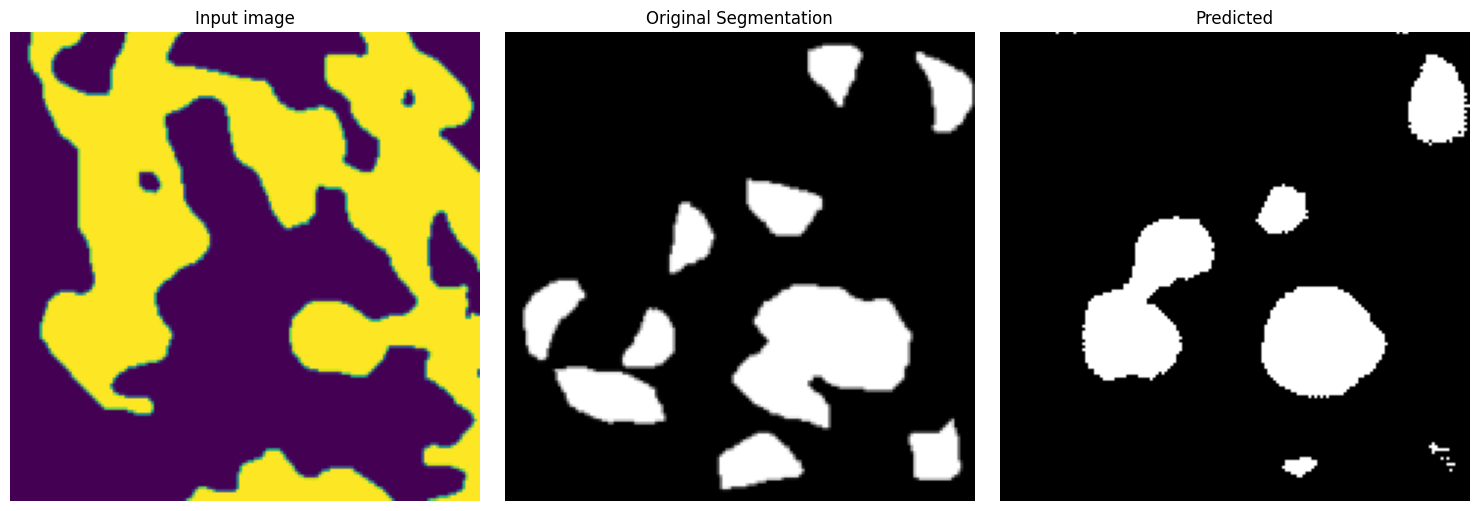

In [41]:
i = 20
j = 2
for s, v, m in test_dataset:
  sample = s
  vec = v
  mask = m
  j += 1
  if j == i:
    break
model.eval()
sample = sample.to(device)
vec = vec.to(device)
pred = model(sample.unsqueeze(0), vec.unsqueeze(0)).detach().cpu()
# print(f"input shape: {sample.shape}")
# print(f"mask shape: {mask.shape}")
# print(f"pred shape: {pred.shape}")

sample = nn.Sigmoid()(sample).detach().cpu().squeeze().numpy()
mask = nn.Sigmoid()(mask).detach().cpu().squeeze().numpy()
pred = (nn.Sigmoid()(pred) >= 0.3).float().detach().cpu().squeeze().numpy()

# sample = sample.transpose(1, 2, 0)

print(f"input shape: {sample.shape}")
print(f"mask shape: {mask.shape}")
print(f"pred shape: {pred.shape}")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(sample)
axes[0].set_title("Input image")
axes[0].axis('off')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title("Original Segmentation")
axes[1].axis('off')

axes[2].imshow(pred, cmap='gray')
axes[2].set_title("Predicted")
axes[2].axis('off')

plt.tight_layout()
plt.show()